In [1]:
from scipy.spatial.distance import mahalanobis
from scipy.stats import (
    zscore, 
    ttest_1samp, 
    ttest_ind,
    ttest_rel
)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import seaborn as sns

In [2]:
input_data = pd.read_csv(r'C:\Users\ams-duongn.EXPEDITORS\Desktop\learn\Data Science Master\M5W4\16PF\data.csv', delimiter = '\s+')

In [3]:
#let's inspect the data
input_data.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,P7,P8,P9,P10,age,gender,accuracy,country,source,elapsed
0,1,4,2,3,3,2,3,4,4,3,...,1,2,5,2,17,1,92,US,6,914.0
1,4,3,4,3,4,4,4,4,2,2,...,3,2,2,2,37,1,100,US,1,891.0
2,3,4,4,4,4,4,4,3,2,2,...,2,3,3,3,31,1,80,US,6,903.0
3,4,5,4,4,4,3,3,2,2,2,...,2,3,4,4,32,1,93,US,1,806.0
4,4,0,4,4,4,3,5,1,2,4,...,4,2,3,2,46,2,87,NZ,1,1826.0


**Step 1: Build a plot where you fit a regression line for the ‘accuracy’ column with a feature you find sensible and motivate your choice.**

In [4]:
#numerical statistics of accuracy feature
input_data.accuracy.describe()

count    4.915900e+04
mean     4.764119e+04
std      9.704611e+06
min      1.000000e+00
25%      8.500000e+01
50%      9.000000e+01
75%      9.700000e+01
max      2.147484e+09
Name: accuracy, dtype: float64

My first thought is to research whether there is a correlation between the amount of time respondents spend on answering the survey with their self-scored accuracy. Since I believe that people spend more time on the survey might score themselves higher as they feel more confident on their answers.

In [5]:
working_data = input_data.copy()

In [6]:
#replace all accuracy numbers higher than 100 to 100 (assuming the conventional scale of up to 100, it doesnt add any info if accuracy is higher than 100)
working_data.accuracy.replace(working_data.accuracy[working_data.accuracy > 100], 100, inplace=True)

working_data.accuracy.describe()

count    49159.000000
mean        88.386684
std         12.534136
min          1.000000
25%         85.000000
50%         90.000000
75%         97.000000
max        100.000000
Name: accuracy, dtype: float64

In [7]:
working_data['elapsed_minute'] = working_data.elapsed // 60
working_data.interpolate(method='linear', limit_direction='forward', axis=0, inplace=True)
working_data.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,P8,P9,P10,age,gender,accuracy,country,source,elapsed,elapsed_minute
0,1,4,2,3,3,2,3,4,4,3,...,2,5,2,17,1,92,US,6,914.0,15.0
1,4,3,4,3,4,4,4,4,2,2,...,2,2,2,37,1,100,US,1,891.0,14.0
2,3,4,4,4,4,4,4,3,2,2,...,3,3,3,31,1,80,US,6,903.0,15.0
3,4,5,4,4,4,3,3,2,2,2,...,3,4,4,32,1,93,US,1,806.0,13.0
4,4,0,4,4,4,3,5,1,2,4,...,2,3,2,46,2,87,NZ,1,1826.0,30.0


In [8]:
working_data.elapsed_minute.describe()

count     49159.000000
mean         41.278657
std         847.137144
min           0.000000
25%           9.000000
50%          12.000000
75%          17.000000
max      142243.000000
Name: elapsed_minute, dtype: float64

In [9]:
#calculate the percentage of outliers data within this feature population
(working_data[(working_data.elapsed_minute < 1) | (working_data.elapsed_minute > 180)].elapsed_minute.count() / working_data.elapsed_minute.count())*100

1.7962122907300802

From the above calculation, we can drop the outliers of around 1% of total data points to have more meaningful results on correlation plots.

In [10]:
#drop datapoints where users spend less than a minute or more than 3 hourse to complete the whole survey.
working_data.drop(working_data[(working_data.elapsed_minute < 1) | (working_data.elapsed_minute > 180)].index, inplace=True)
working_data.elapsed_minute.describe()

count    48276.000000
mean        15.960840
std         15.330122
min          1.000000
25%          9.000000
50%         12.000000
75%         17.000000
max        180.000000
Name: elapsed_minute, dtype: float64

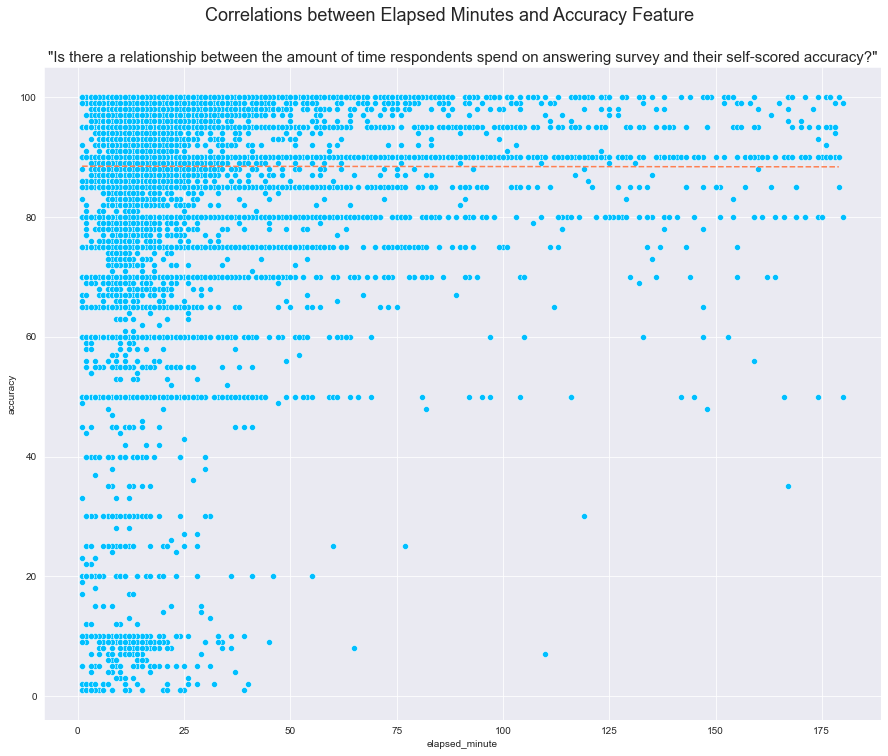

In [11]:
#Based on the hypothesis that the longer respondents spend on answering the survey, they will score themselves higher on accuracy of their answers
#By that I draw a scatterplot between these two variables and fit a simple regression line

fig = plt.figure(figsize=(15, 12))

sns.set_style("darkgrid")

# define the true objective function for linear regression
def objective(x, a, b):
	return a * x + b

data = working_data.values

# choose the input and output variables for accuracy vs elapsed_minute
x1, y1 = data[:, 169], data[:, 165]
# curve fit
popt1, _ = curve_fit(objective, x1, y1)
# summarize the parameter values for accuracy vs elapsed_minute
a1, b1 = popt1

#scatter plot the data
ax = sns.scatterplot(x="elapsed_minute", y="accuracy", data=working_data, legend=False, color="deepskyblue")

#setting plot parameters
title_string = "Correlations between Elapsed Minutes and Accuracy Feature"
subtitle_string = '"Is there a relationship between the amount of time respondents spend on answering survey and their self-scored accuracy?"'
plt.suptitle(title_string, y=.95, fontsize=18)
plt.title(subtitle_string, fontsize=15)

# define a sequence of inputs between the smallest and largest known inputs
x1_line = np.arange(min(x1), max(x1), 1)
# calculate the output for the range
y1_line = objective(x1_line, a1, b1)
# create a line plot for the mapping function
plt.plot(x1_line, y1_line, '--', color="coral")


# Tweak spacing between subplots to prevent labels from overlapping
plt.subplots_adjust(hspace=0.2)

plt.show()

From the above diagram, it is apparent that there is no linear correlations between the elapsed minutes that users spend on the survey and the accuracy score. The accuracy score is independent of the elapsed minute feature

My second choice is to research whether there is a correlation between the diversity of responses reflecting from the answers' score means across the portfolio (range from 0-5) with their self-scored accuracy. In my opinion, people who makes more conscious choices on their answers instead of choosing the middle accross their responses will have a tendency to score their answers more accurate.

In [12]:
working_data2 = input_data.copy()
#replace all accuracy numbers higher than 100 to 100
working_data2.accuracy.replace(working_data2.accuracy[working_data2.accuracy > 100], 100, inplace=True)
working_data2['answers_mean'] = working_data2.iloc[:, 0:163].mean(axis=1)
working_data2.answers_mean.describe()

count    49159.000000
mean         3.115163
std          0.339417
min          0.000000
25%          3.030675
50%          3.134969
75%          3.239264
max          5.000000
Name: answers_mean, dtype: float64

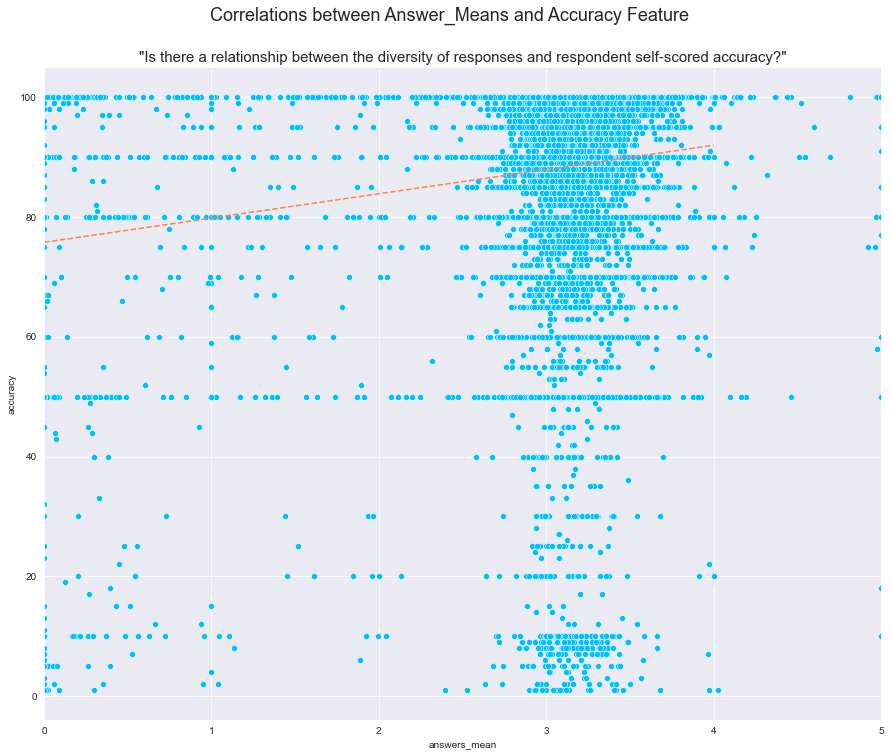

In [13]:
#Based on the hypothesis that if respondents actually put a more diverse profile of responses to the survey, they will score themselves higher on accuracy of their answers
#By that I draw a scatterplot between these two variables and fit a simple regression line

fig = plt.figure(figsize=(15, 12))

sns.set_style("darkgrid")

# define the true objective function for linear regression
def objective(x, a, b):
	return a * x + b

data = working_data2.values

# choose the input and output variables for accuracy vs answers_mean
x1, y1 = data[:, 169], data[:, 165]
# curve fit
popt1, _ = curve_fit(objective, x1, y1)
# summarize the parameter values for accuracy vs answers_mean
a1, b1 = popt1

#scatter plot the data
ax = sns.scatterplot(x="answers_mean", y="accuracy", data=working_data2, legend=False, color="deepskyblue")

#setting plot parameters
title_string = "Correlations between Answer_Means and Accuracy Feature"
subtitle_string = '"Is there a relationship between the diversity of responses and respondent self-scored accuracy?"'
plt.suptitle(title_string, y=.95, fontsize=18)
plt.title(subtitle_string, fontsize=15)
plt.xlim(0,5)

# define a sequence of inputs between the smallest and largest known inputs
x1_line = np.arange(min(x1), max(x1), 1)
# calculate the output for the range
y1_line = objective(x1_line, a1, b1)
# create a line plot for the mapping function
plt.plot(x1_line, y1_line, '--', color="coral")


# Tweak spacing between subplots to prevent labels from overlapping
plt.subplots_adjust(hspace=0.2)

plt.show()

From the above chart, we can conclude that there is indeed a linear correlation between the diversity of the survey responses choices with the accuracy score that users give themselves. In more details, users who gives more disagreeness to the survey questions tend to score themselves lower and vice versa.

My last approach is to research whether there is a correlation between the respondents' age (assuming they faithfully report their age) with their self-scored accuracy. Perhaps the older the person is, that person might score themselves higher as they reflect through their life experience.

In [14]:
working_data3 = input_data.copy()
#replace all accuracy numbers higher than 100 to 100
working_data3.accuracy.replace(working_data3.accuracy[working_data3.accuracy > 100], 100, inplace=True)
working_data3.interpolate(method='linear', limit_direction='forward', axis=0, inplace=True)
working_data3.age.describe()

count    4.915900e+04
mean     4.371320e+04
std      9.685640e+06
min      1.300000e+01
25%      1.800000e+01
50%      2.100000e+01
75%      3.000000e+01
max      2.147484e+09
Name: age, dtype: float64

In [15]:
#calculate the percentage of outliers data within this feature population
(working_data3[working_data3.age > 70].age.count() / working_data3.age.count())*100

0.2786875241563091

From the above calculation, we can drop the outliers of less than 1% of total data points to have more meaningful results on correlation plots.

In [16]:
#drop datapoints where users' age is higher than 70
working_data3.drop(working_data3[working_data3.age > 70].index, inplace=True)
working_data3.age.describe()

count    49022.000000
mean        25.294521
std         10.931557
min         13.000000
25%         18.000000
50%         21.000000
75%         29.000000
max         70.000000
Name: age, dtype: float64

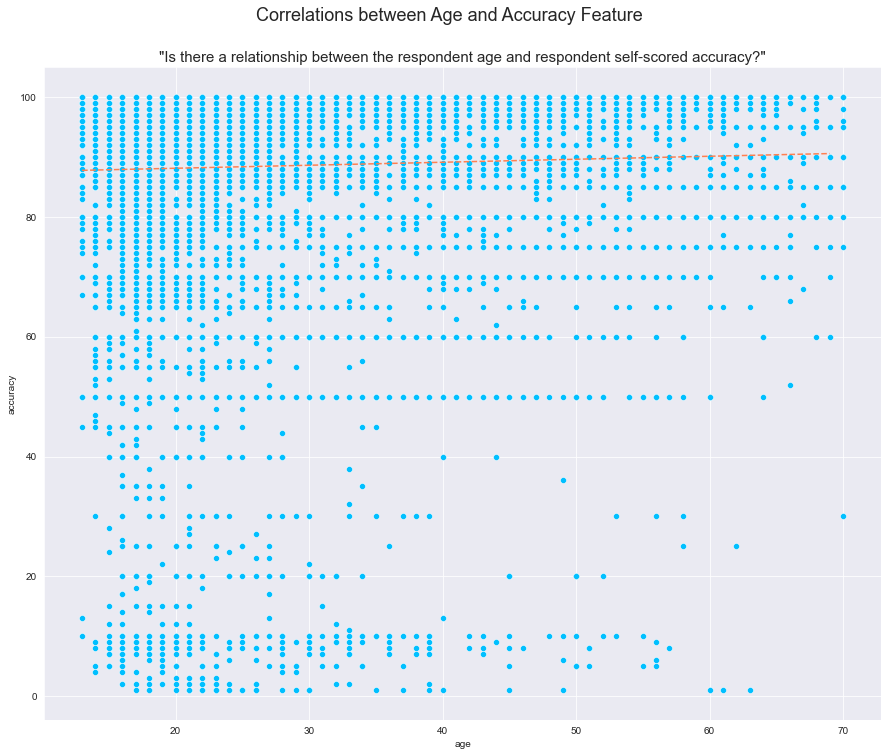

In [17]:
#Based on the hypothesis that the higher the respondents' age, they will score themselves higher on accuracy of their answers
#By that I draw a scatterplot between these two variables and fit a simple regression line

fig = plt.figure(figsize=(15, 12))

sns.set_style("darkgrid")

# define the true objective function for linear regression
def objective(x, a, b):
	return a * x + b

data = working_data3.values

# choose the input and output variables for accuracy vs age
x1, y1 = data[:, 163], data[:, 165]
# curve fit
popt1, _ = curve_fit(objective, x1, y1)
# summarize the parameter values for accuracy vs age
a1, b1 = popt1

#scatter plot the data
ax = sns.scatterplot(x="age", y="accuracy", data=working_data3, legend=False, color="deepskyblue")

#setting plot parameters
title_string = "Correlations between Age and Accuracy Feature"
subtitle_string = '"Is there a relationship between the respondent age and respondent self-scored accuracy?"'
plt.suptitle(title_string, y=.95, fontsize=18)
plt.title(subtitle_string, fontsize=15)

# define a sequence of inputs between the smallest and largest known inputs
x1_line = np.arange(min(x1), max(x1), 1)
# calculate the output for the range
y1_line = objective(x1_line, a1, b1)
# create a line plot for the mapping function
plt.plot(x1_line, y1_line, '--', color="coral")


# Tweak spacing between subplots to prevent labels from overlapping
plt.subplots_adjust(hspace=0.2)

plt.show()

From the above graph, once again, there is little evidence for correlations between respondents' age and the accuracy score.

**Step 2: Look at the responses of men and women using only answers of people from your country (or as a backup, pick Turkey). Test whether men and women provide different answers to 5 questions of your choice.**

In [18]:
working_data4 = input_data.copy()
#filter the input data to only respondents come from Turkey(TR) and with gender either male(1) or female(2)
working_data4 = working_data4.loc[(working_data4.country == "TR") & ((working_data4.gender == 1) | (working_data4.gender == 2))]
working_data4.describe(include='all')

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,P7,P8,P9,P10,age,gender,accuracy,country,source,elapsed
count,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,...,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151,151.000000,151.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TR,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,151,NaN,NaN
mean,3.609272,3.556291,3.715232,3.357616,3.668874,3.476821,3.516556,2.516556,2.165563,2.516556,...,2.430464,3.000000,3.443709,3.417219,26.913907,1.410596,84.827815,NaN,2.245033,1369.629139
std,1.243509,1.407768,1.266899,1.271977,1.175992,1.248116,1.182395,1.279866,1.157183,1.210258,...,1.257033,1.270171,1.192397,1.261521,8.407093,0.493579,19.657657,NaN,1.777515,1749.164127
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,13.000000,1.000000,2.000000,NaN,1.000000,17.000000
25%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2.000000,1.000000,2.000000,...,2.000000,2.000000,3.000000,3.000000,20.000000,1.000000,80.000000,NaN,1.000000,703.000000
50%,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,2.000000,2.000000,2.000000,...,2.000000,3.000000,4.000000,4.000000,25.000000,1.000000,90.000000,NaN,2.000000,981.000000
75%,4.000000,4.000000,4.500000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,3.000000,...,3.000000,4.000000,4.000000,4.000000,32.500000,2.000000,95.000000,NaN,2.000000,1420.000000


Test whether men and women provide different answers to the question regarding the statement: "I take an interest in other people's lives" (A4)

In [19]:
ttest_ind(working_data4.loc[working_data4.gender == 1]['A4'], working_data4.loc[working_data4.gender == 2]['A4'])

Ttest_indResult(statistic=-2.490713014922588, pvalue=0.013845866831232028)

The test result for this question shows that there is strong probability that there is indeed difference in answers between women and men that is not from random chance (pvalue < 0.05) Hence we reject the hypothesis that women and men have similar answers on this question.

Test whether men and women provide different answers to the question regarding the statement: "I reflect on things before acting" (B7)

In [20]:
ttest_ind(working_data4.loc[working_data4.gender == 1]['B7'], working_data4.loc[working_data4.gender == 2]['B7'])

Ttest_indResult(statistic=-0.2934880768181739, pvalue=0.7695574987925549)

The test result for this question shows that there is insufficient statistical evidence that there is difference in answers between women and men that is not from random chance (pvalue > 0.05). Hence we cannot reject the hypothesis that women and men have similar answers on this question.

Test whether men and women provide different answers to the question regarding the statement: "I have frequent mood swings" (C6)

In [21]:
ttest_ind(working_data4.loc[working_data4.gender == 1]['C6'], working_data4.loc[working_data4.gender == 2]['C6'])

Ttest_indResult(statistic=-3.5634260066542636, pvalue=0.0004921199776063277)

The test result for this question shows that there is strong probability that there is indeed difference in answers between women and men that is not from random chance (pvalue < 0.05) Hence we reject the hypothesis that women and men have similar answers on this question.

Test whether men and women provide different answers to the question regarding the statement: "I take charge" (D1)

In [22]:
ttest_ind(working_data4.loc[working_data4.gender == 1]['D1'], working_data4.loc[working_data4.gender == 2]['D1'])

Ttest_indResult(statistic=-0.04153262971673729, pvalue=0.9669268823791214)

The test result for this question shows that there is insufficient statistical evidence that there is difference in answers between women and men that is not from random chance (pvalue > 0.05). Hence we cannot reject the hypothesis that women and men have similar answers on this question.

Test whether men and women provide different answers to the question regarding the statement: "I dislike loud music" (E10)

In [23]:
ttest_ind(working_data4.loc[working_data4.gender == 1]['E10'], working_data4.loc[working_data4.gender == 2]['E10'])

Ttest_indResult(statistic=-0.7067968178951085, pvalue=0.48079661640492233)

The test result for this question shows that there is insufficient statistical evidence that there is difference in answers between women and men that is not from random chance (pvalue > 0.05). Hence we cannot reject the hypothesis that women and men have similar answers on this question.